<a href="https://colab.research.google.com/github/roesta07/Business-Analysis-Template/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
# Imports and utility functions
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install pymc3==3.8
    !pip install --upgrade daft
    !pip install --upgrade theano
    !pip install causalgraphicalmodels
    !pip install watermark
    !pip install arviz --no-dependencies
    !pip install netCDF4
    !pip install xarray

Requirement already up-to-date: daft in /usr/local/lib/python3.6/dist-packages (0.1.0)
Requirement already up-to-date: theano in /usr/local/lib/python3.6/dist-packages (1.0.5)


In [165]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import daft
from theano import theano

from scipy.interpolate import griddata
from causalgraphicalmodels import CausalGraphicalModel

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
# %load_ext watermark
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [166]:

np.random.seed(3)
## we are going to be simulating data for 10 years
N=14*12

profit=np.zeros(N)
## for seven years marketing predicted profit
y_7=7*12
M_exp=np.zeros(N)
RD_exp=np.zeros(N)
M_exp[:y_7]=stats.halfnorm(0.35,0.2).rvs(y_7)
RD_exp[:y_7]=stats.halfnorm(0.25,0.5).rvs(y_7)
profit[:y_7]=stats.norm(M_exp[:y_7]*10,1).rvs(y_7)
RD_exp[y_7:]=stats.halfnorm(0.25,0.6).rvs(size=(N-y_7))
M_exp[y_7:]=stats.halfnorm(RD_exp[y_7:]+0.15,0.5).rvs(N-y_7)
profit[y_7:]=stats.norm(RD_exp[y_7:]*10,2).rvs((N-y_7))
## y as year 0-10
y=np.arange(1,15)
# each year has 12months
m=np.array(list(np.arange(1,13))*14)

print(len(m),len(y),N/len(y),len(profit),)

168 14 12.0 168


In [167]:
df=pd.DataFrame({
    'year':np.repeat(y,N/len(y),axis=0),
    'month':m,
    'RD_exp':RD_exp,
    'M_exp':M_exp,
    'profit': profit,
})
df.head()

,year,month,RD_exp,M_exp,profit
0,1,1,0.322532,0.707726,6.006671
1,1,2,0.833941,0.437302,4.743890
2,1,3,0.262052,0.369299,4.555827
3,1,4,0.694329,0.722699,6.578553
4,1,5,1.707869,0.405478,3.623886


In [168]:
# it will be easy to work with standarize data
def standarize(col):
  return (col-col.mean())/col.std()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


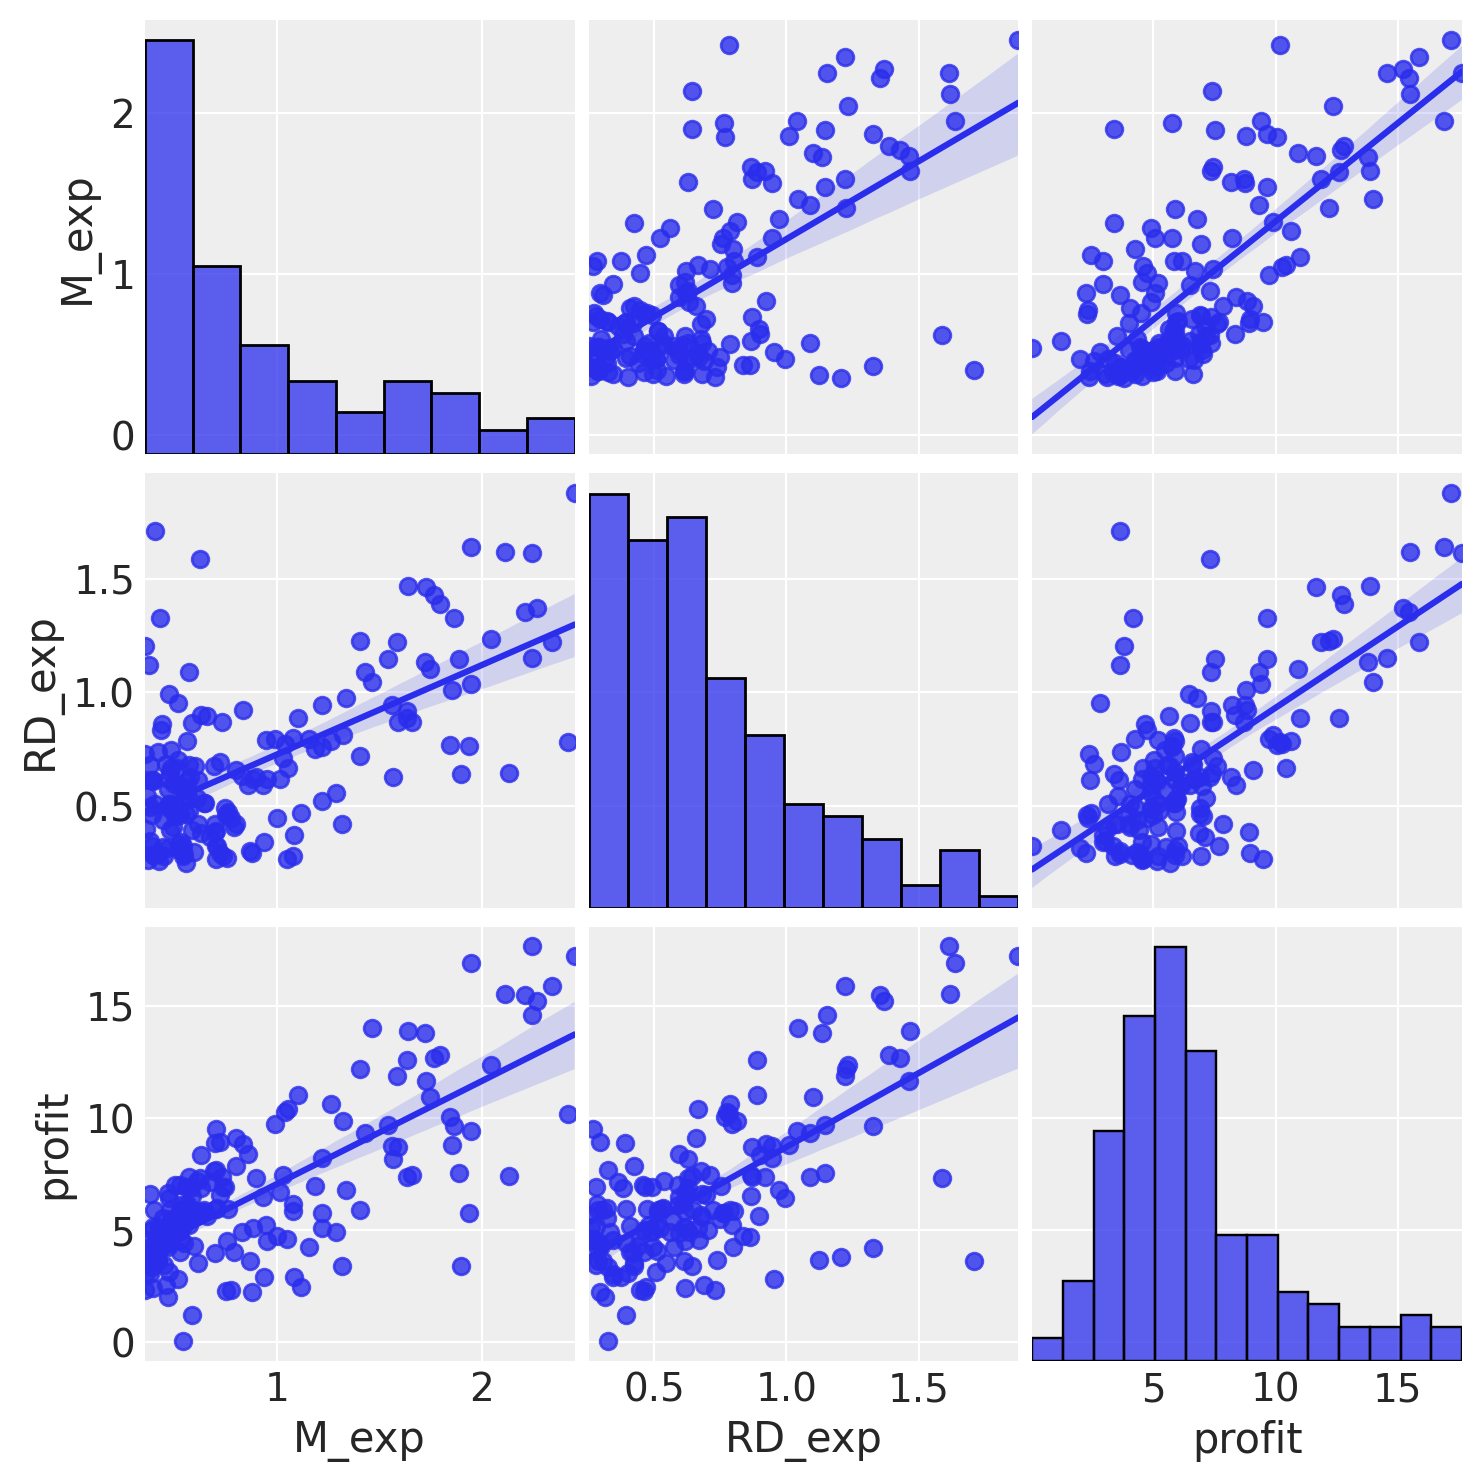

In [169]:
sns.pairplot(df[['M_exp','RD_exp','profit']],kind='reg')

In [170]:
## standarize columns
d=df.assign(M_std=standarize(df['M_exp']),RD_std=standarize(df['RD_exp']),P_std=standarize(df['profit']))

In [171]:
M_shared=theano.shared(d['M_std'].values)
RD_shared=theano.shared(d['RD_std'].values)
with pm.Model() as m4_1:
  a=pm.Normal('a',0,0.2)
  bM=pm.Normal('bM',0,0.5)
  bR=pm.Normal('bR',0,0.5)
  sigma=pm.Exponential('sigma',1)
  mu=pm.Deterministic('mu', a + bM*M_shared + bR*RD_shared)
  profit=pm.Normal('profit',mu=mu,sigma=sigma,observed=d['P_std'])
  trace4_1=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bR, bM, a]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:01<00:00, 809.76it/s]


In [172]:
az.summary(trace4_1,kind='stats',round_to=2,var_names=['~mu'])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.00,0.04,-0.07,0.07
bM,0.52,0.06,0.42,0.61
bR,0.36,0.06,0.28,0.46
sigma,0.61,0.03,0.55,0.66


In [173]:

m4_ppc=pm.sample_posterior_predictive(trace4_1,1000,m4_1,var_names=['mu','profit'])
mu_hpd=az.hpd(m4_ppc['mu'],hdi_prob=0.89)

100%|██████████| 1000/1000 [00:01<00:00, 687.69it/s]
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


Text(0.5, 1.0, 'Posterior Predictive')

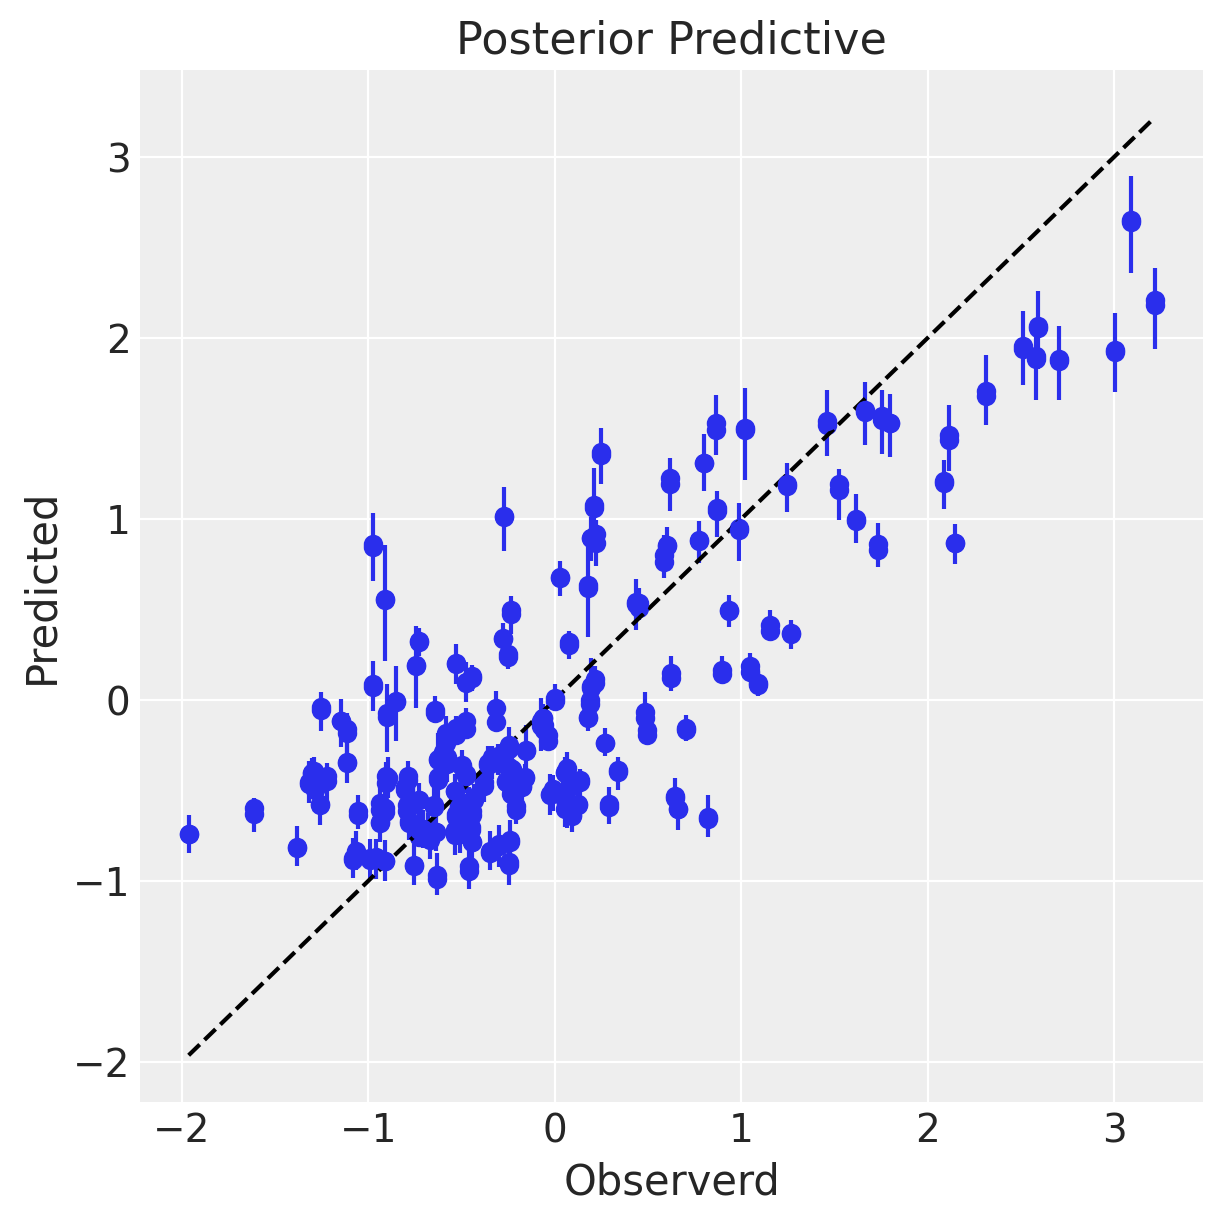

In [174]:
## posterior predictive plot
fig,ax=plt.subplots(figsize=(6,6))
ax.errorbar(d['P_std'],m4_ppc['mu'].mean(0),
            yerr=np.absolute(mu_hpd.T-m4_ppc['mu'].mean(0)),
            fmt="C0o")
ax.scatter(d['P_std'],m4_ppc['profit'].mean(0))
min,max=d['P_std'].min(),d['P_std'].max()
ax.plot([[min],[max]],[[min],[max]],'k--')
ax.set_xlabel('Observerd')
ax.set_ylabel('Predicted')
ax.set_title('Posterior Predictive')

In [175]:
filt=d['P_std']-m4_ppc['mu'].mean(0)>1
d.loc[filt]

,year,month,RD_exp,M_exp,profit,M_std,RD_std,P_std
43,4,8,0.388034,0.698628,8.897109,-0.409218,-0.874920,0.644673
57,5,10,0.294208,0.722178,8.944448,-0.366666,-1.140330,0.658627
73,7,2,0.267472,0.703925,9.496842,-0.399646,-1.215959,0.821456
106,9,11,0.667290,1.055240,10.411919,0.235142,-0.084979,1.091193
117,10,10,1.639515,1.949310,16.907595,1.850630,2.665183,3.005923
147,13,4,1.613346,2.245728,17.627248,2.386226,2.591159,3.218054
156,14,1,1.044693,1.465445,13.982298,0.976338,0.982592,2.143633


In [176]:
yearly_df=d.groupby(['year']).mean()
yearly_df.head(14)

,month,RD_exp,M_exp,profit,M_std,RD_std,P_std
year,,,,,,,
1,6.5,0.635093,0.487442,4.631588,-0.790808,-0.176056,-0.612674
2,6.5,0.643687,0.522241,4.889153,-0.727931,-0.151748,-0.536752
3,6.5,0.562420,0.538933,5.609247,-0.697770,-0.381630,-0.324490
4,6.5,0.580485,0.511030,5.604600,-0.748188,-0.330529,-0.325859
5,6.5,0.593911,0.590658,5.947727,-0.604308,-0.292550,-0.224716
6,6.5,0.541334,0.528294,5.610480,-0.716994,-0.441275,-0.324126
7,6.5,0.665360,0.513751,5.988728,-0.743272,-0.090439,-0.212630
8,6.5,0.701484,1.387842,7.081306,0.836117,0.011746,0.109429
9,6.5,0.764434,1.206289,8.200203,0.508072,0.189815,0.439246


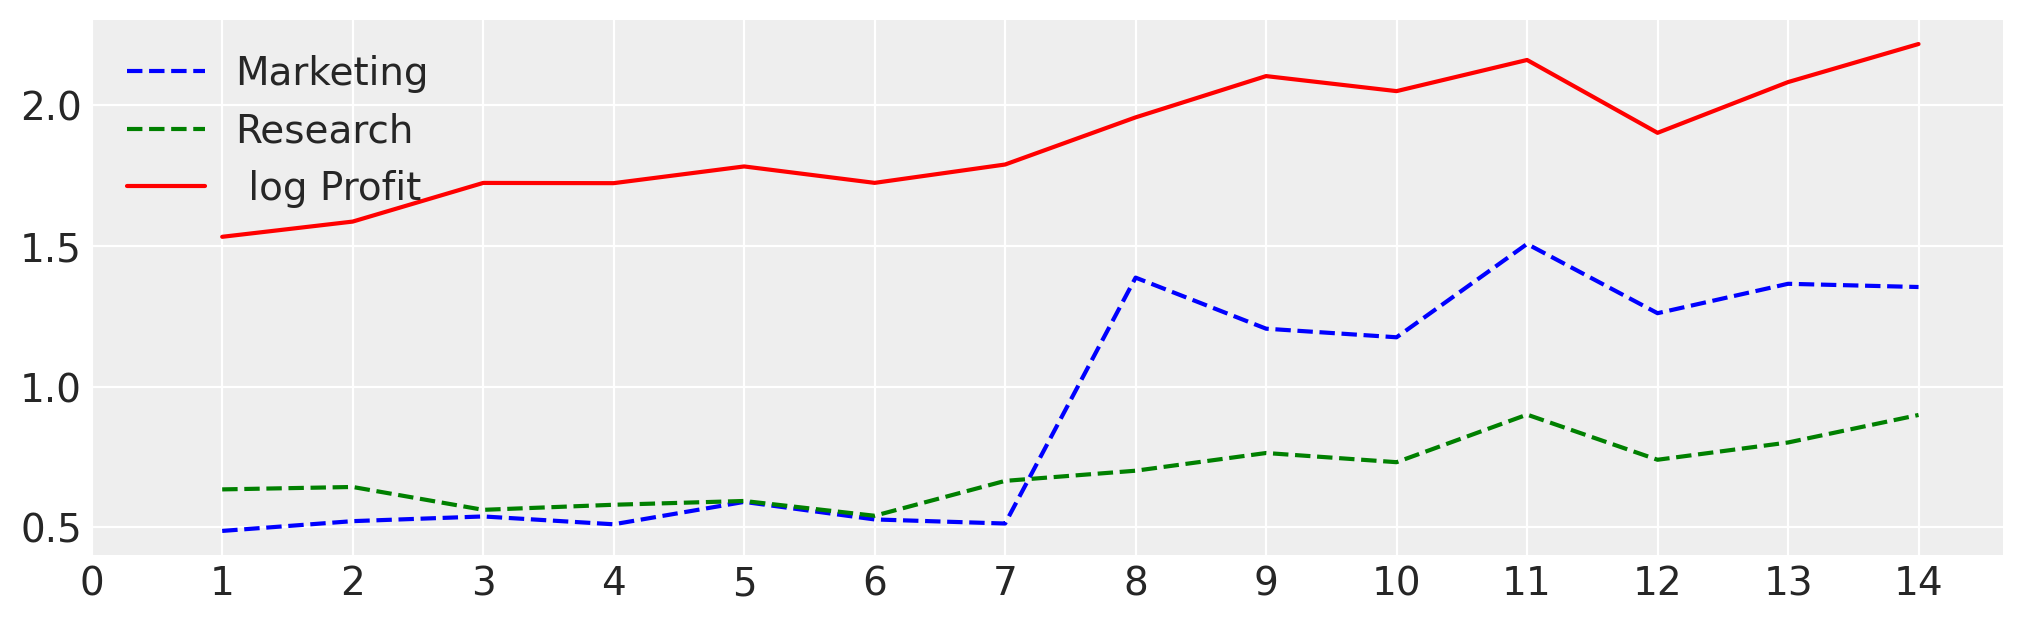

In [177]:
fig,ax=plt.subplots(figsize=(10,3))
ax.plot(yearly_df.index,yearly_df['M_exp'],'--b',label='Marketing')
ax.plot(yearly_df.index,yearly_df['RD_exp'],'--g',label='Research')
ax.plot(yearly_df.index,np.log(yearly_df['profit']),'r',label=' log Profit')
ax.set_xticks(np.arange(0,15))
ax.legend()


In [178]:
M_shared_first=theano.shared(d['M_std'][:y_7].values)
RD_shared_first=theano.shared(d['RD_std'][:y_7].values)

with pm.Model() as m4_7:
  a=pm.Normal('a',0,0.2)
  bM=pm.Normal('bM',0,0.5)
  bR=pm.Normal('bR',0,0.5)
  sigma=pm.Exponential('sigma',1)
  mu=pm.Deterministic('mu', a + bM*M_shared_first + bR*RD_shared_first)
  profit=pm.Normal('profit',mu=mu,sigma=sigma,observed=d['P_std'][:y_7])
  trace4_7=pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bR, bM, a]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:02<00:00, 420.26it/s]


In [179]:
az.summary(trace4_7,round_to=2,var_names=['~mu'])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.59,0.12,0.41,0.77,0.01,0.00,358.80,358.80,366.70,420.43,1.00
bM,1.36,0.16,1.10,1.59,0.01,0.01,365.08,365.08,366.92,407.85,1.00
bR,-0.01,0.05,-0.07,0.07,0.00,0.00,730.63,396.22,730.63,583.11,1.01
sigma,0.33,0.03,0.28,0.38,0.00,0.00,623.85,615.86,636.51,524.57,1.00


In [180]:

M_shared_later=theano.shared(d['M_std'][y_7:].values)
RD_shared_later=theano.shared(d['RD_std'][y_7:].values)
with pm.Model() as m4_l7:
  a=pm.Normal('a',0,0.2)
  bM=pm.Normal('bM',0,0.5)
  bR=pm.Normal('bR',0,0.5)
  sigma=pm.Exponential('sigma',1)
  mu=pm.Deterministic('mu', a + bM*M_shared_later + bR*RD_shared_later)
  profit=pm.Normal('profit',mu=mu,sigma=sigma,observed=d['P_std'][y_7:])
  trace4_l7=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bR, bM, a]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:01<00:00, 637.31it/s]


In [181]:
az.summary(trace4_l7,round_to=2,kind='stats',var_names=['~mu'])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.01,0.08,-0.11,0.13
bM,0.19,0.11,0.01,0.36
bR,0.82,0.10,0.68,0.98
sigma,0.59,0.05,0.51,0.67


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


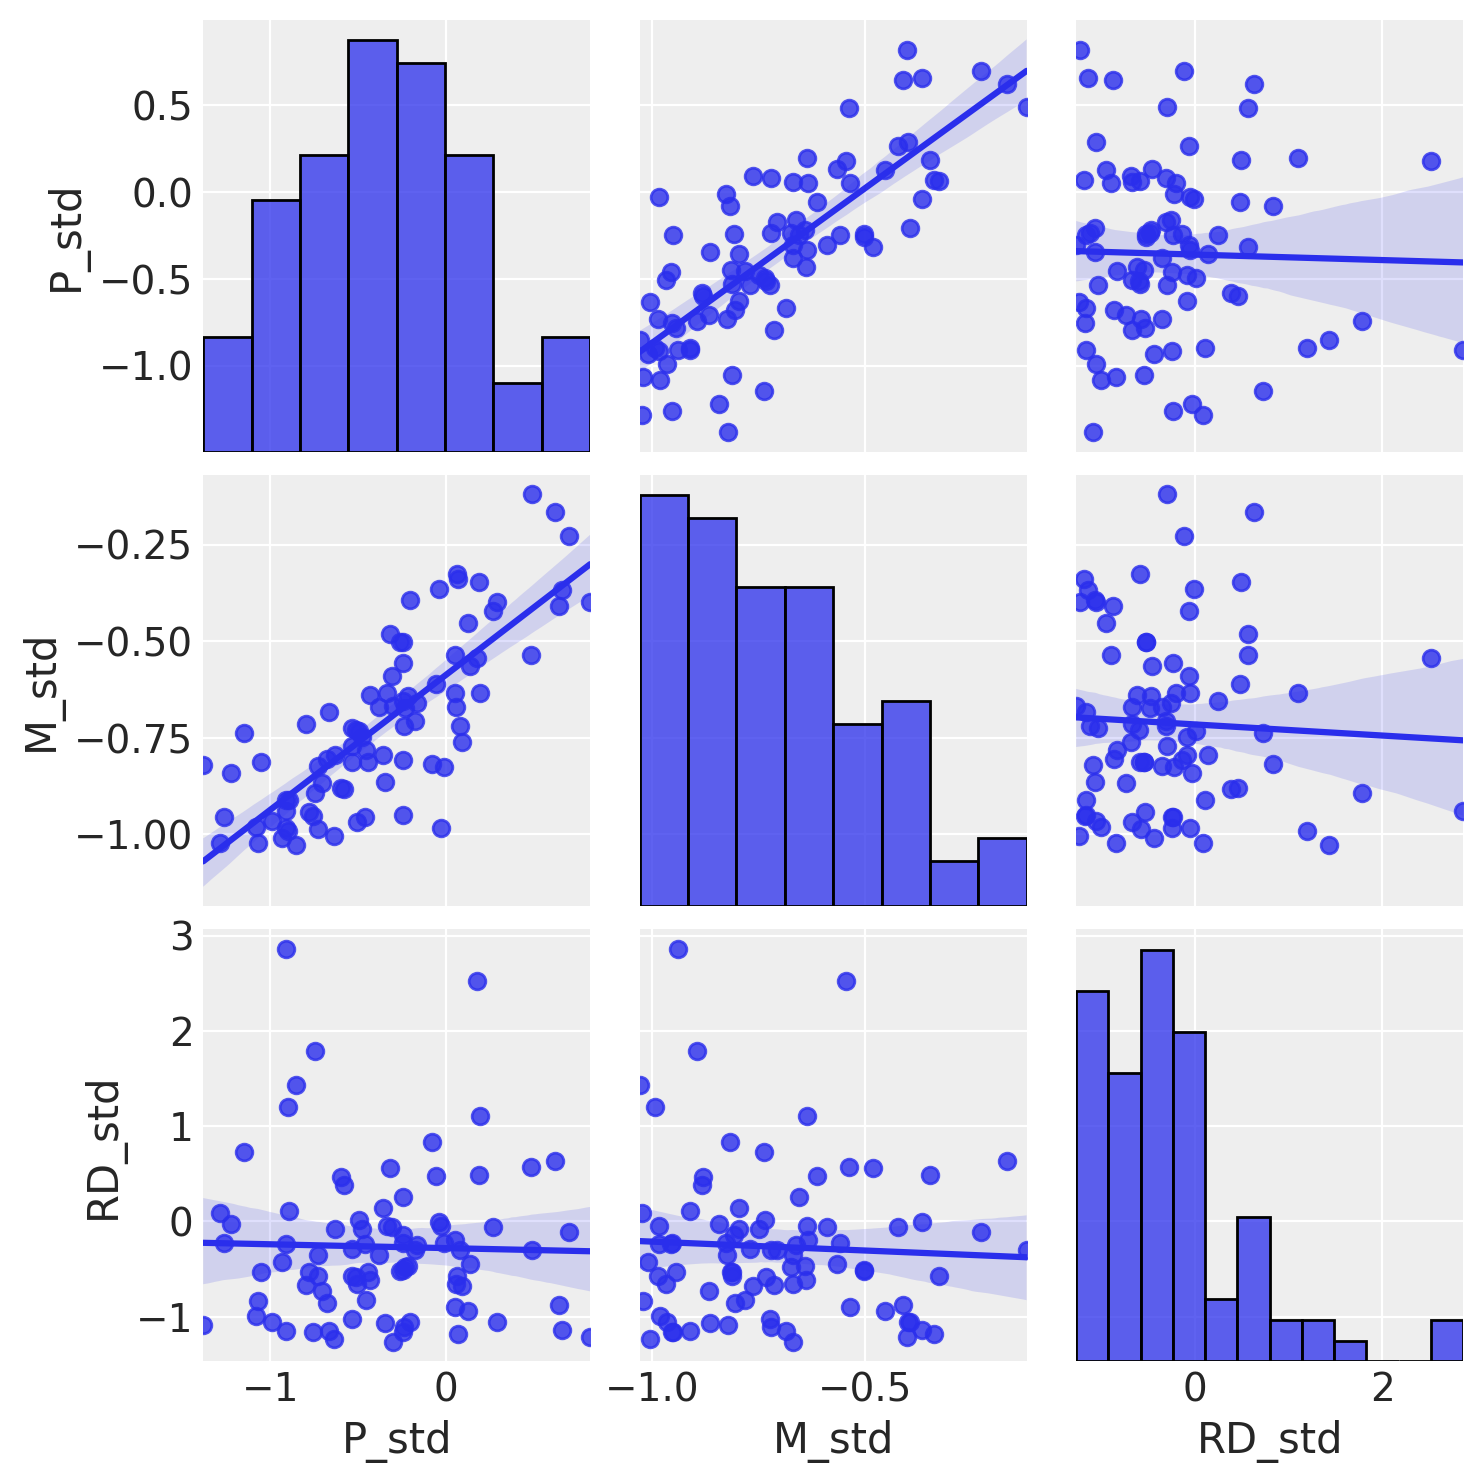

In [182]:
sns.pairplot(d.loc[:y_7,['P_std','M_std','RD_std']],kind='reg')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


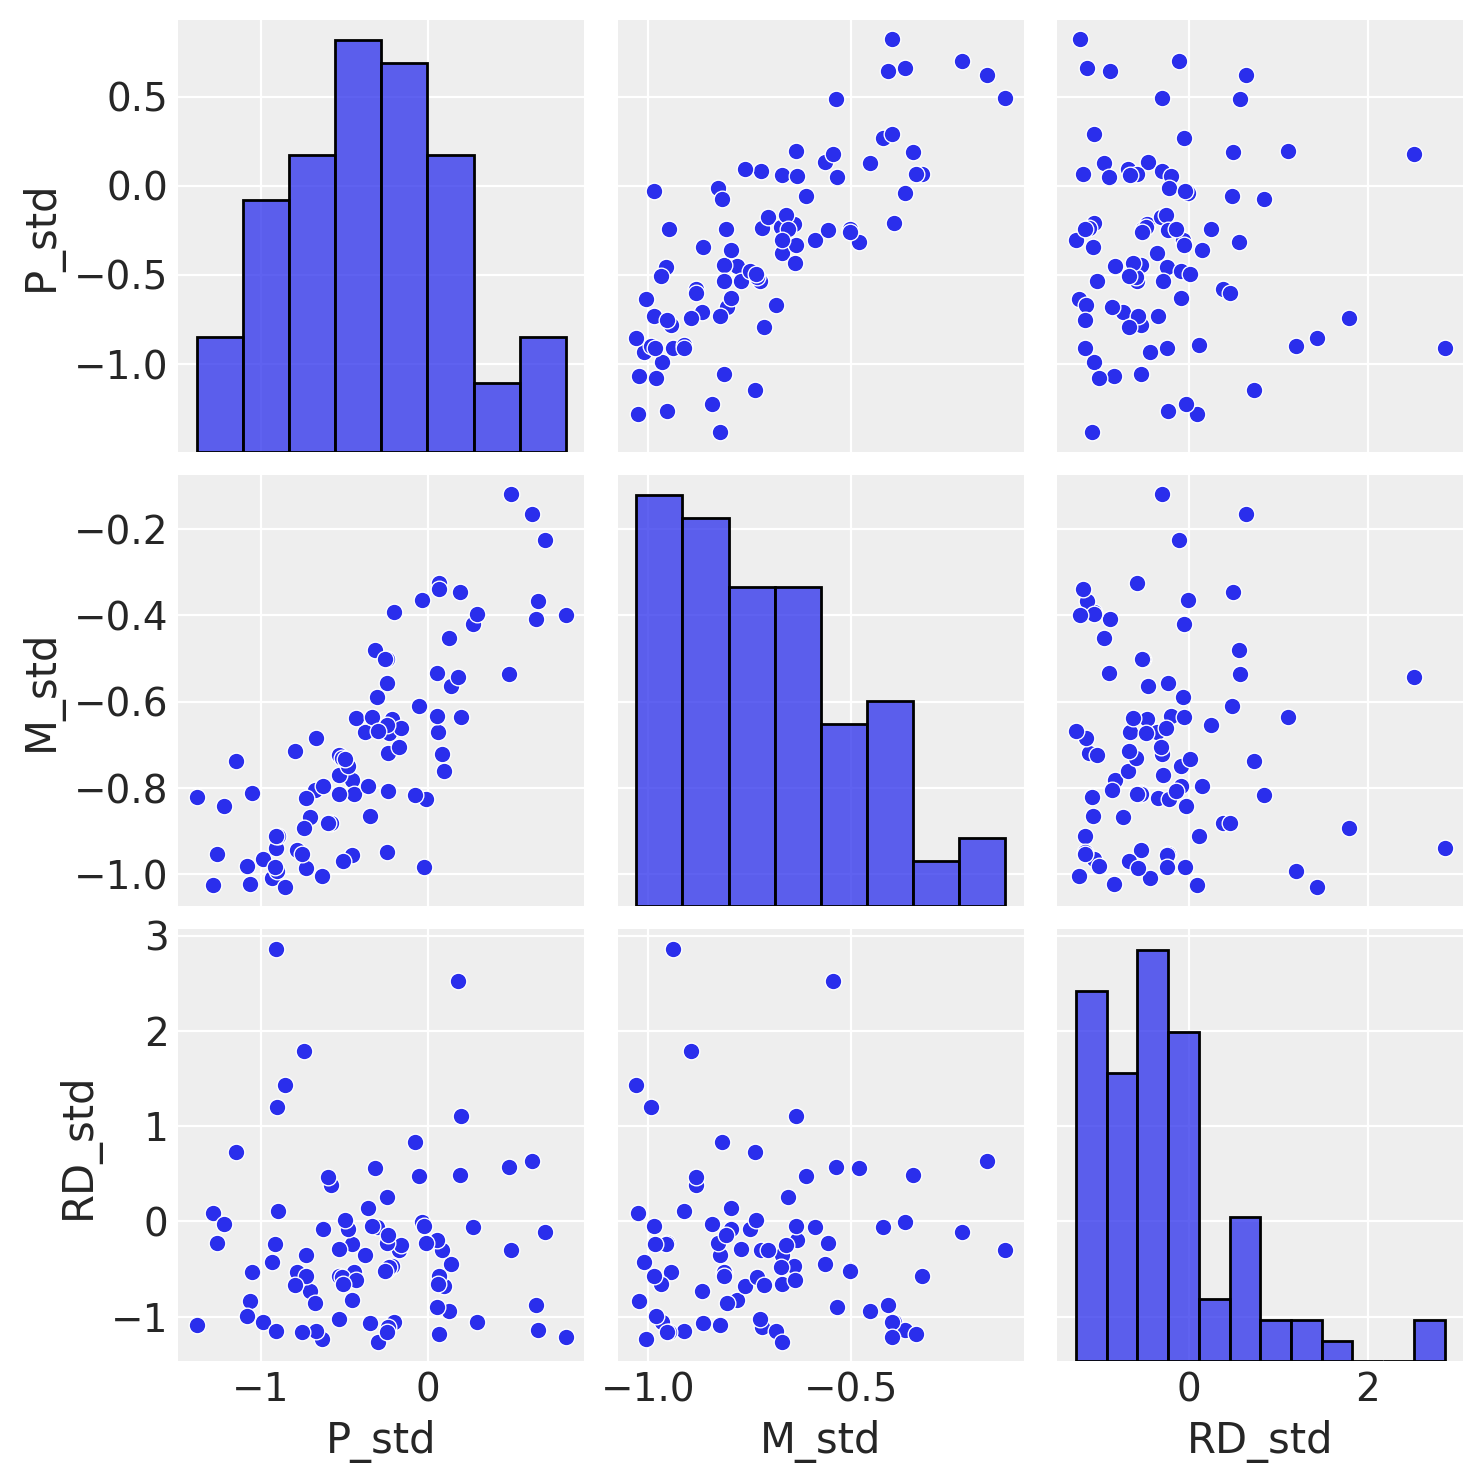

In [183]:
d_y7=d.loc[:y_7,['P_std','M_std','RD_std']]
sns.pairplot(d_y7)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


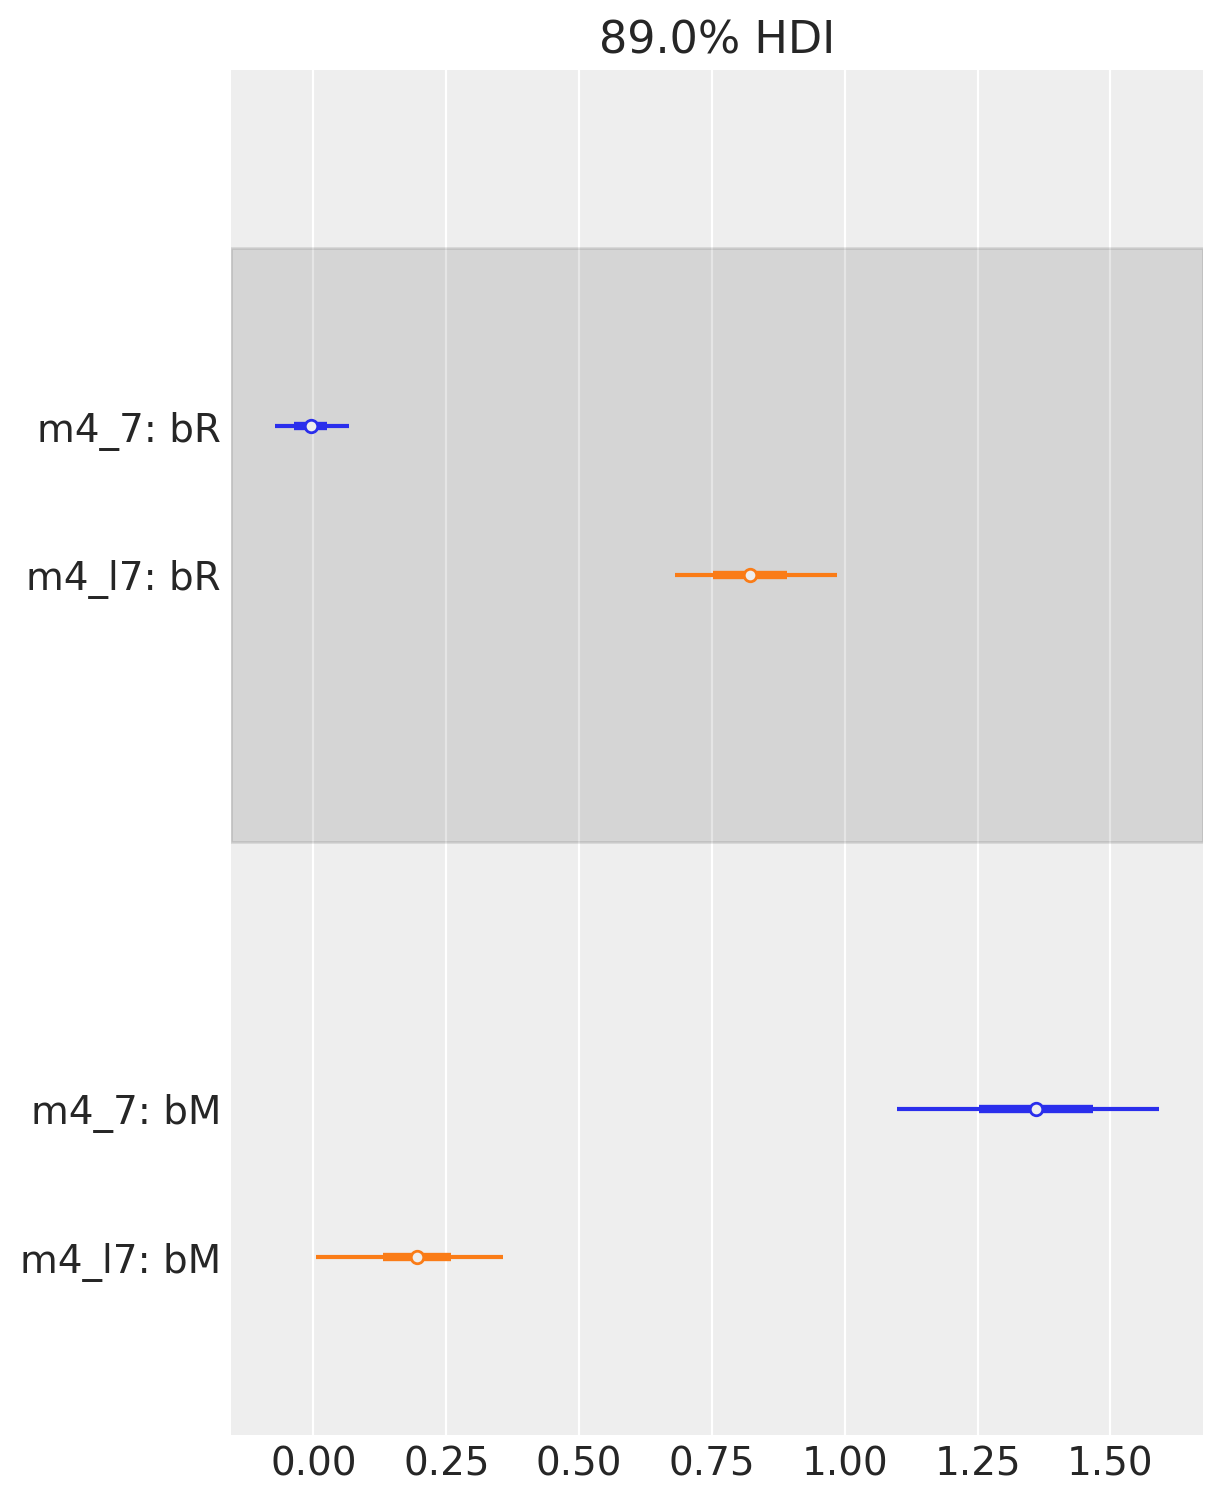

In [184]:
coeftab = {
           "m4_7": trace4_7,
           "m4_l7": trace4_l7}

az.plot_forest(list(coeftab.values()), model_names=list(coeftab.keys()),combined=True,
               var_names=["bR", "bM"], hdi_prob=0.89,);

In [185]:
M_cons_first7=np.zeros(len(d['M_std'][:y_7]))
M_shared_first.set_value(M_cons_first7)
RD_changed_first7=np.linspace(-2,2,len(d['RD_std'][:y_7]))
RD_shared_first.set_value(RD_changed_first7)
m4_7_counter_first7=pm.sample_posterior_predictive(trace4_7,200,m4_7)

##
M_cons_later7=np.zeros(len(d['M_std'][y_7:]))
RD_changed_later7=np.linspace(-2,2,len(d['M_std'][y_7:]))

M_shared_later.set_value(M_cons_later7)
RD_shared_later.set_value(RD_changed_later7)

m4_3y_counter_later7=pm.sample_posterior_predictive(trace4_l7,200,m4_l7)


/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 556.81it/s]


In [186]:
RD_cons_first7=np.zeros(len(d['RD_std'][:y_7]))
M_changed_first7=np.linspace(-2,2,len(d['M_std'][:y_7]))
M_shared_first.set_value(M_changed_first7)

RD_shared_first.set_value(RD_changed_first7)
m4_7_counterM_first7=pm.sample_posterior_predictive(trace4_7,200,m4_7)

##
RD_cons_later7=np.zeros(len(d['RD_std'][y_7:]))
M_changed_later7=np.linspace(-2,2,len(d['M_std'][y_7:]))

M_shared_later.set_value(M_changed_later7)
RD_shared_later.set_value(RD_cons_later7)

m4_3y_counterM_later7=pm.sample_posterior_predictive(trace4_l7,200,m4_l7)

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 752.82it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


Text(0.5, 1.0, 'Later Seven Years')

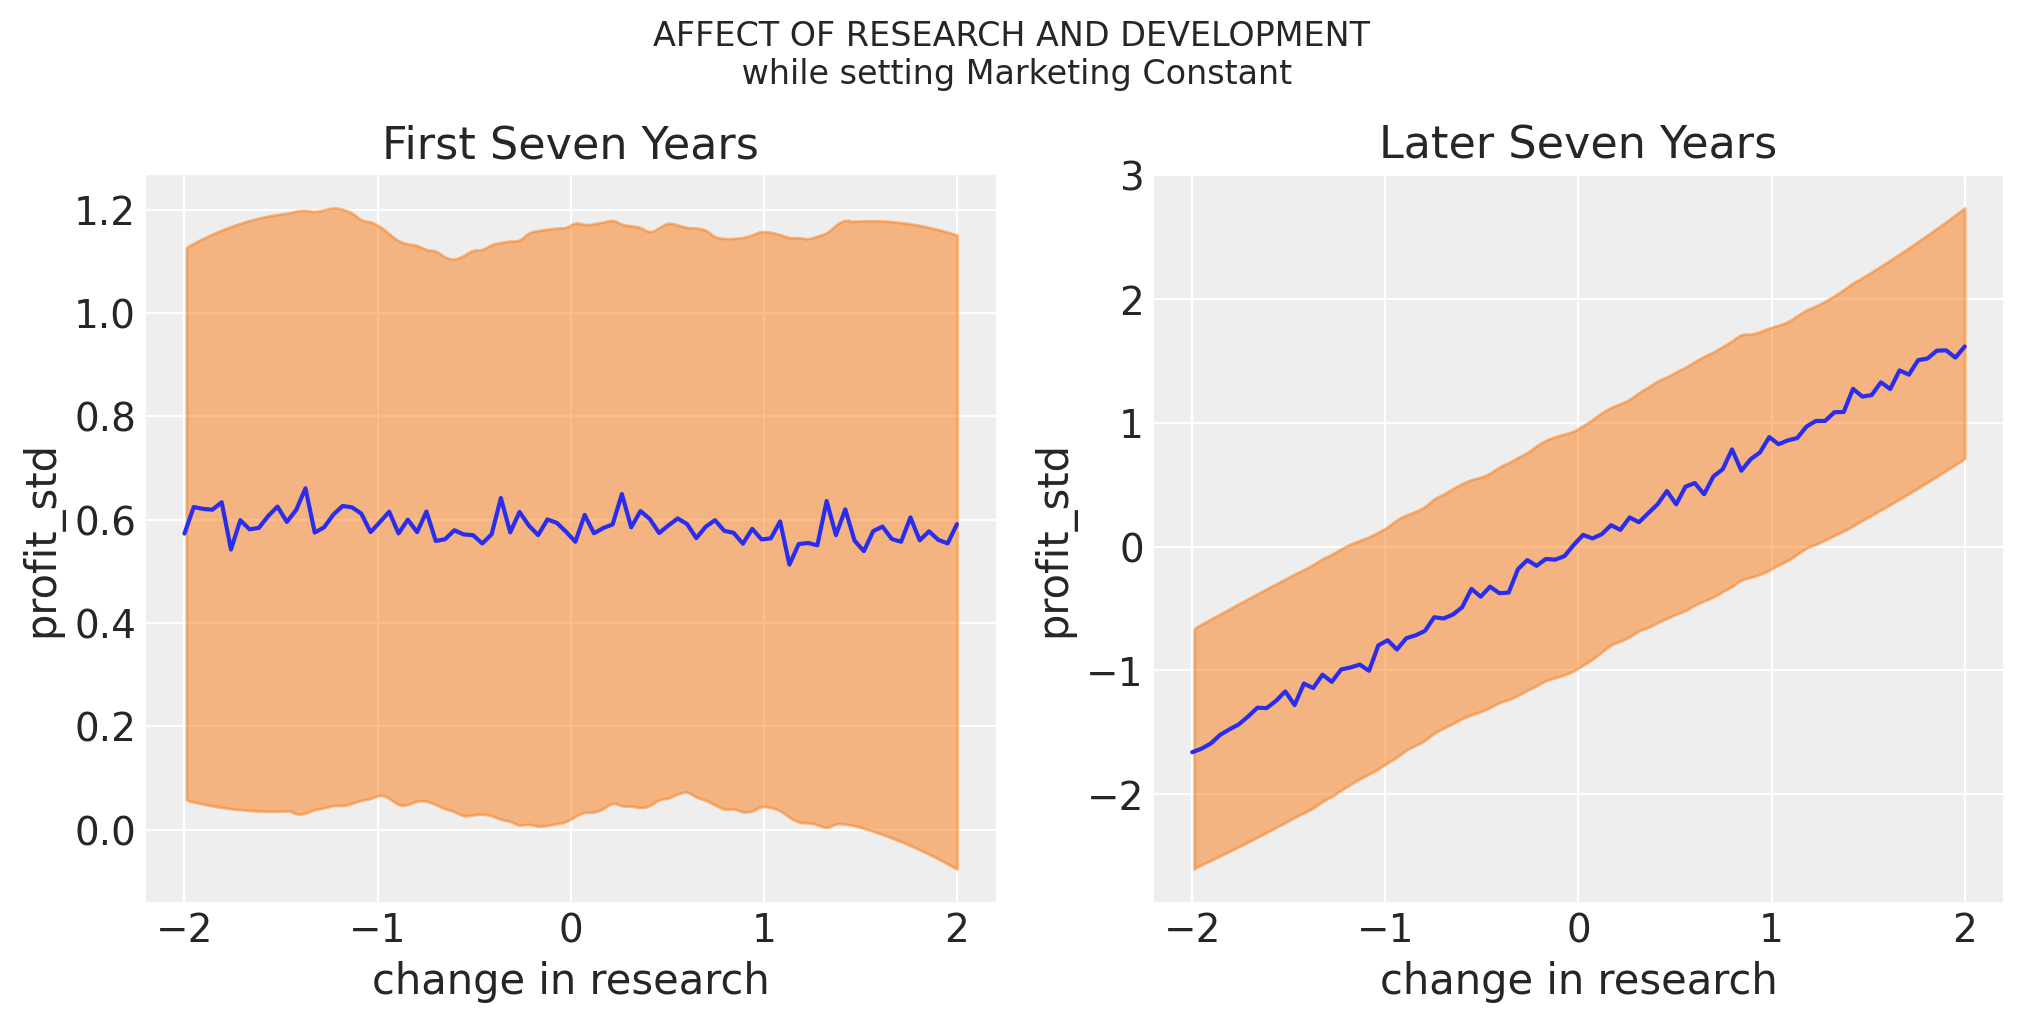

In [187]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(RD_changed_first7,m4_7_counter_first7['profit'].mean(0))
az.plot_hpd(RD_changed_first7,m4_7_counter_first7['profit'],ax=ax[0])
ax[1].plot(RD_changed_later7,m4_3y_counter_later7['profit'].mean(0))
az.plot_hpd(RD_changed_later7,m4_3y_counter_later7['profit'],ax=ax[1])

ax[0].set_xlabel('change in research')
ax[1].set_xlabel('change in research')
ax[0].set_ylabel('profit_std')
ax[1].set_ylabel('profit_std')
fig.suptitle('AFFECT OF RESEARCH AND DEVELOPMENT\n while setting Marketing Constant')
ax[0].set_title('First Seven Years')
ax[1].set_title('Later Seven Years')


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


Text(0.5, 1.0, 'Later Seven Years')

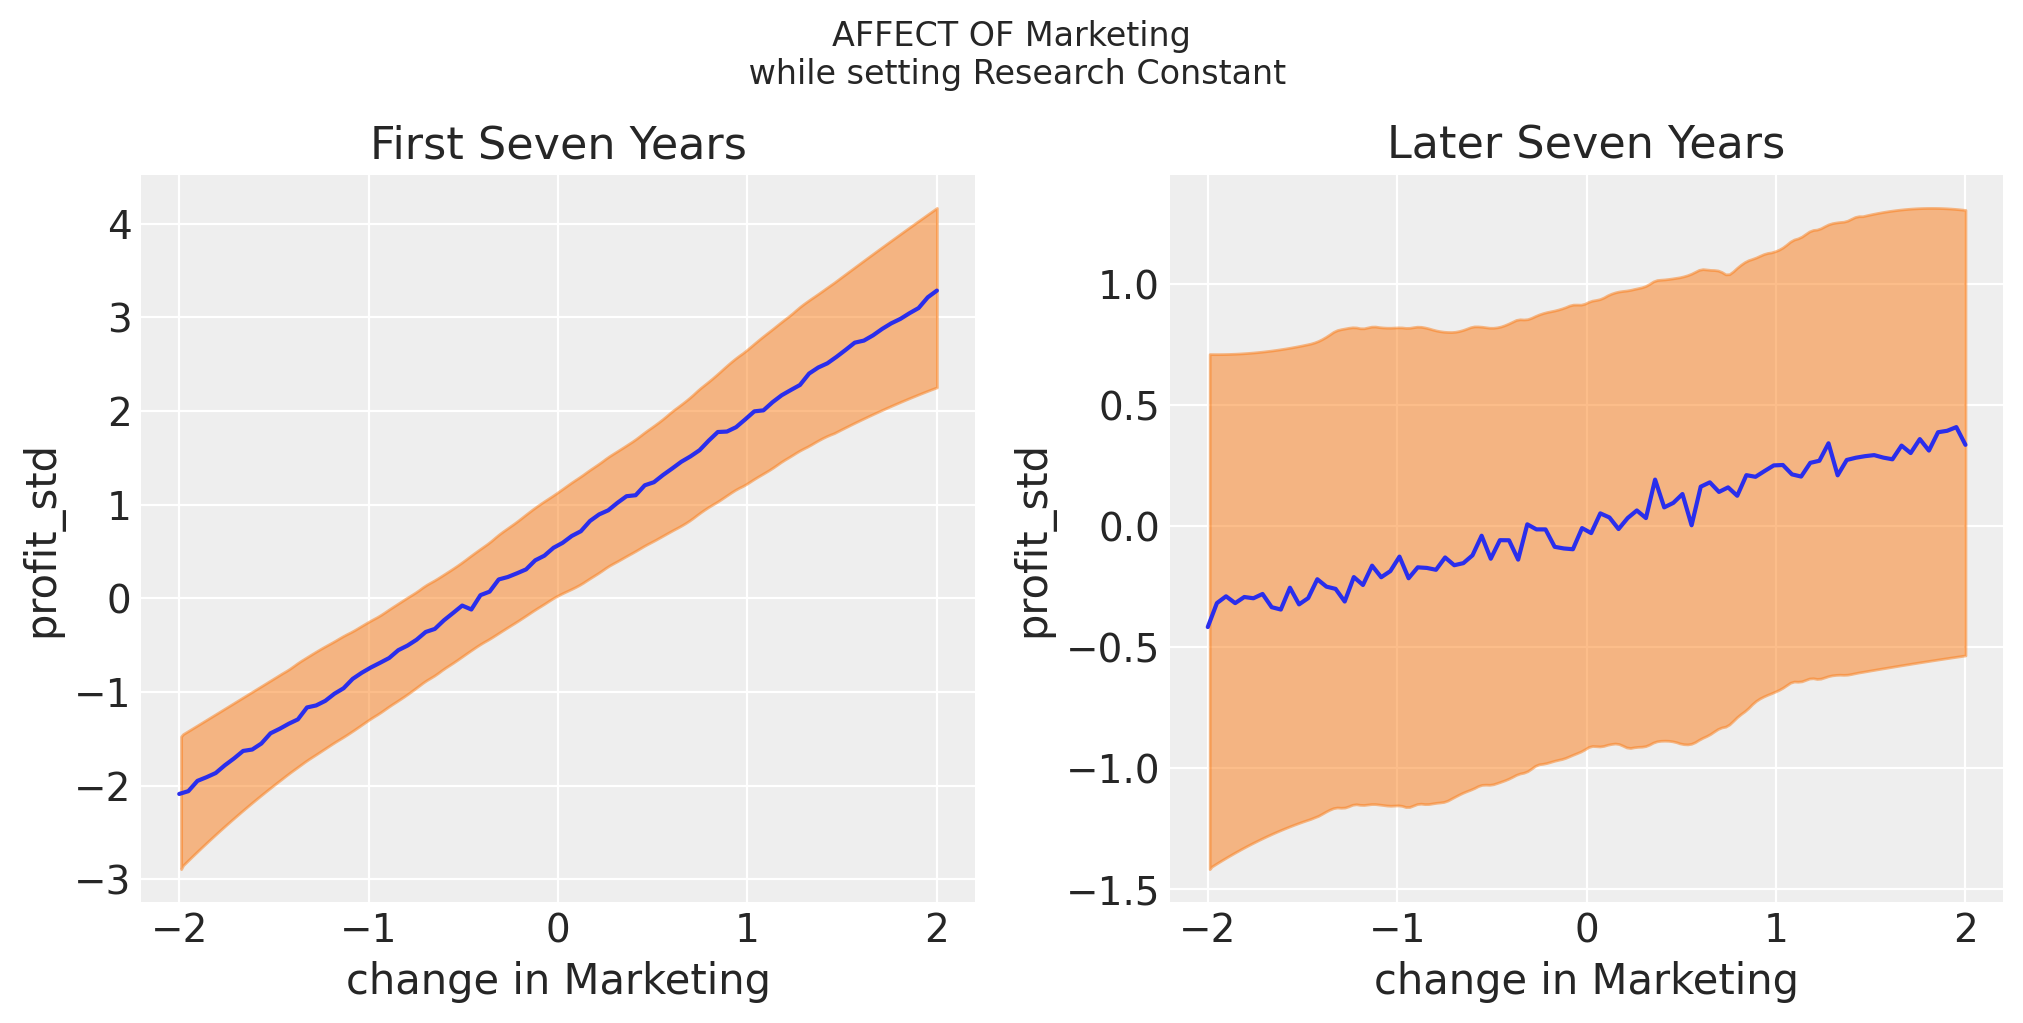

In [188]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(M_changed_first7,m4_7_counterM_first7['profit'].mean(0))
az.plot_hpd(M_changed_first7,m4_7_counterM_first7['profit'],ax=ax[0])
ax[1].plot(M_changed_later7,m4_3y_counterM_later7['profit'].mean(0))
az.plot_hpd(M_changed_later7,m4_3y_counterM_later7['profit'],ax=ax[1])

ax[0].set_xlabel('change in Marketing')
ax[1].set_xlabel('change in Marketing')
ax[0].set_ylabel('profit_std')
ax[1].set_ylabel('profit_std')
fig.suptitle('AFFECT OF Marketing\n while setting Research Constant')
ax[0].set_title('First Seven Years')
ax[1].set_title('Later Seven Years')

In [201]:
## now lets see how the model predicts

M_shared_first.set_value(d['M_std'][:y_7].values)
RD_shared_first.set_value(d['RD_std'][:y_7].values)

M_shared_later.set_value(d['M_std'][y_7:].values)
RD_shared_later.set_value(d['RD_std'][y_7:].values)

m4_7_ppc=pm.sample_posterior_predictive(trace4_7,1000,m4_7,var_names=['mu','profit'])
m4_l7_ppc=pm.sample_posterior_predictive(trace4_l7,1000,m4_l7,var_names=['mu','profit'])

mu_first=m4_7_ppc['mu'].mean(0)
mu_later=m4_l7_ppc['mu'].mean(0)
mu_first_hpd=az.hpd(m4_7_ppc['mu'],hdi_prob=0.89)
mu_later_hpd=az.hpd(m4_l7_ppc['mu'],hdi_prob=0.89)

100%|██████████| 1000/1000 [00:01<00:00, 646.39it/s]
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


In [202]:
print(len(d['P_std'][:y_7]))
print(d['RD_std'][:y_7][3]*0.92+d['M_std'][:y_7][3]*-0.01,mu_first[3],d['P_std'][3])
print(M_shared_first.get_value()[0])
d['M_std'][:y_7].values

84
-0.004158162223870065 0.09201225038225554 -0.038767383664929406
-0.39277962436847486


array([-0.39277962, -0.88140625, -1.00427943, -0.3657253 , -0.9389094 ,
       -0.91094926, -1.00925055, -0.81256696, -1.02331659, -0.86669519,
       -0.56434904, -0.71946801, -0.72066213, -0.42134855, -1.02107046,
       -0.89290981, -0.84207017, -0.48028785, -0.68414505, -0.64124935,
       -0.61090118, -0.96483408, -0.50208944, -0.95360736, -0.66917758,
       -0.78149111, -0.81320144, -0.98114546, -0.7613106 , -0.95602338,
       -0.76990421, -0.32502754, -0.58955209, -0.81277792, -0.74868774,
       -0.16494684, -0.70531294, -0.66914483, -0.63297005, -0.99148057,
       -0.45253104, -0.80545692, -0.91040294, -0.40921781, -0.82353517,
       -0.82644617, -0.72334925, -1.02841361, -0.22667947, -0.94238815,
       -0.6730088 , -0.73096872, -0.63867638, -0.6346278 , -0.5015854 ,
       -0.63502169, -0.73348551, -0.36666603, -0.82128181, -0.34730246,
       -0.66037354, -0.55716734, -0.96781011, -0.39783294, -0.79531951,
       -0.98472184, -0.98388025, -0.65457422, -0.88088704, -0.33

Text(0.5, 0.98, 'Posterior Predictive')

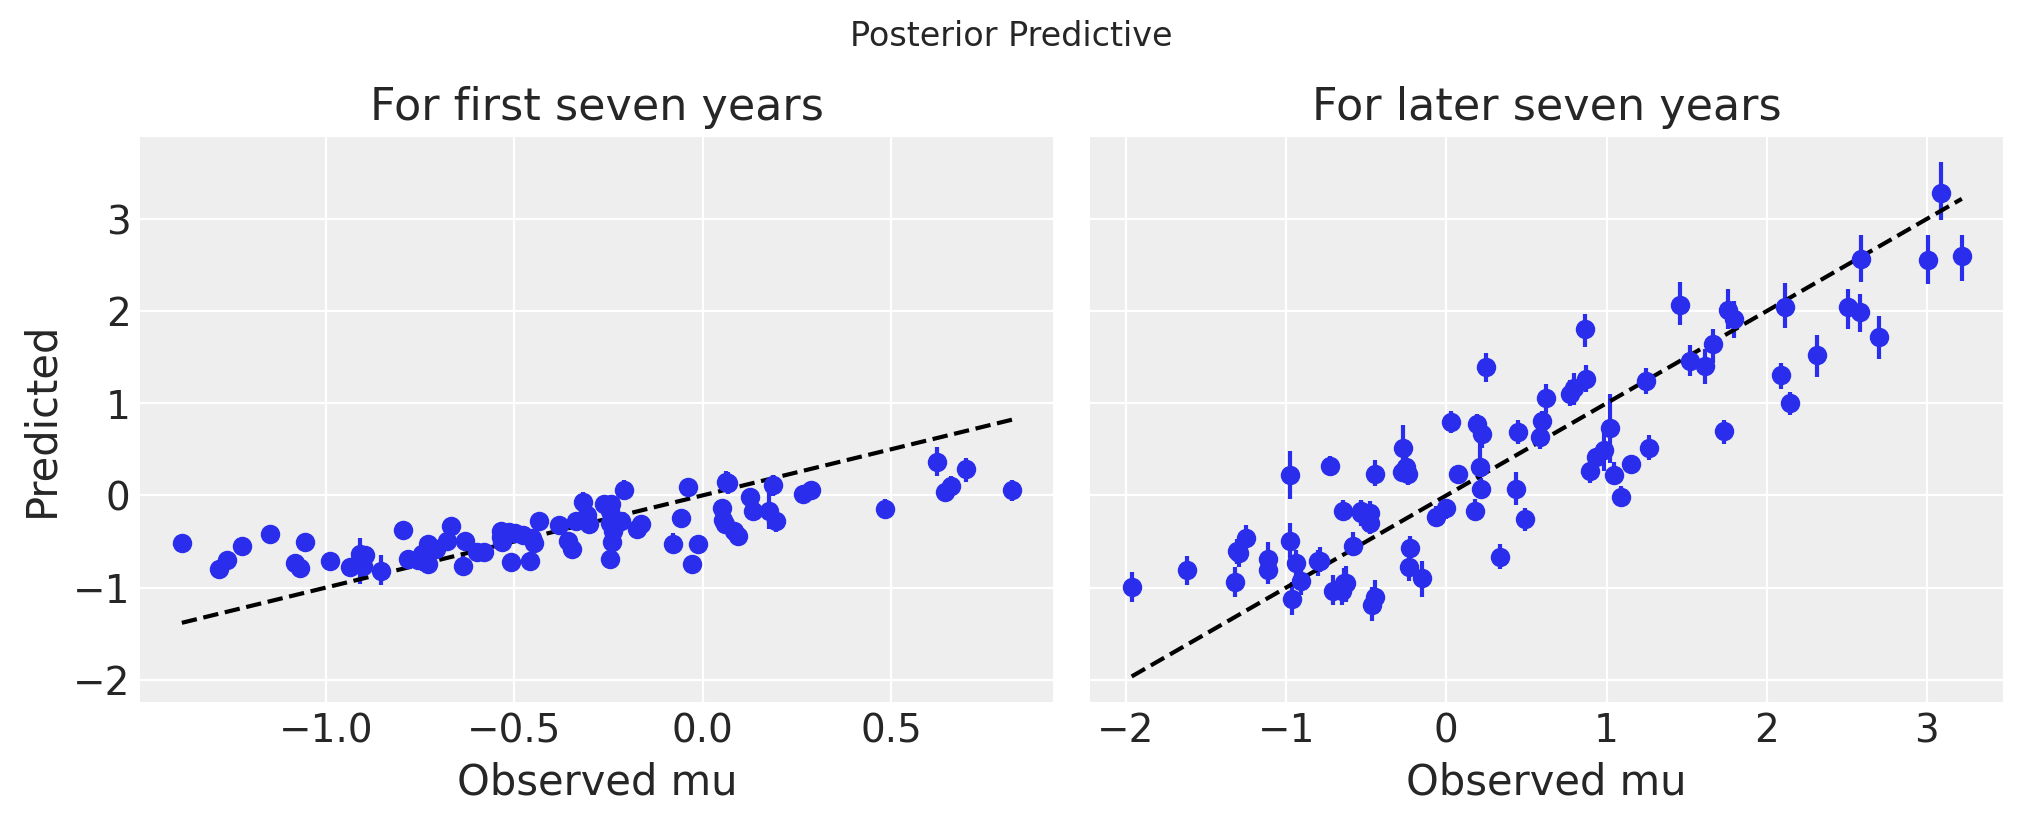

In [204]:
fig,ax=plt.subplots(1,2,figsize=(10,4),sharey=True)
ax[0].errorbar(d['P_std'][:y_7],mu_first,
               yerr=np.absolute(mu_first-mu_first_hpd.T),
               fmt="C0o")
max_first,min_first=d['P_std'][:y_7].max(),d['P_std'][:y_7].min()
ax[0].plot([min_first,max_first],[min_first,max_first],'k--')

ax[1].errorbar(d['P_std'][y_7:],mu_later,
               yerr=np.absolute(mu_later-mu_later_hpd.T),
               fmt="C0o")
max_later,min_later=d['P_std'][y_7:].max(),d['P_std'][y_7:].min()
ax[1].plot([min_later,max_later],[min_later,max_later],'k--')
ax[0].set_xlabel('Observed mu')
ax[1].set_xlabel('Observed mu')
ax[0].set_ylabel('Predicted')
ax[0].set_title('For first seven years')
ax[1].set_title('For later seven years')
fig.suptitle('Posterior Predictive')
